In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes
import numpy as np
from pathlib import Path

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy.highlevel as phl

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import src.config as config

In [2]:
import src.loadProcessed as loadp
from scipy.stats import norm

counts = loadp.load_selected_count()
counts['is_weekend'] = counts['day'].isin(['Saturday', 'Sunday'])
log_counts = counts.copy()
log_counts['daily_count'] = log_counts['daily_count'].apply(np.log)

## Justifying log transformation

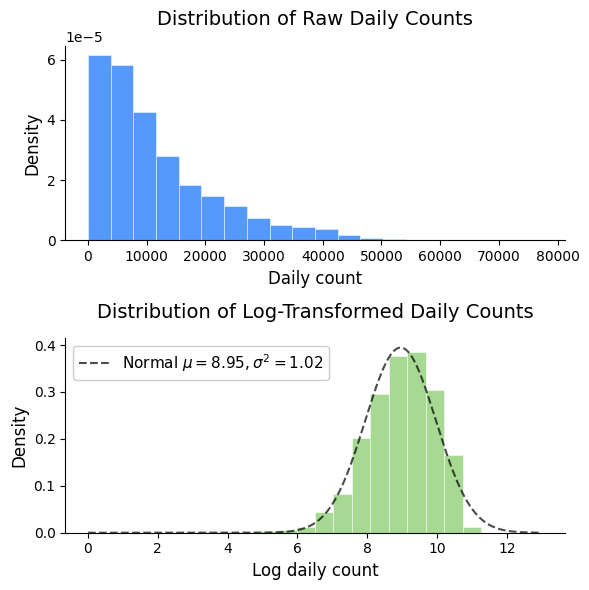

In [3]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))

ax1.hist(counts['daily_count'], bins=20, color='#0d6efd', alpha=0.7, edgecolor='white', linewidth=0.5, density=True)
ax1.set_xlabel("Daily count", fontsize=12)
ax1.set_ylabel("Density", fontsize=12)
ax1.set_title("Distribution of Raw Daily Counts", fontsize=14, pad=15)
# ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.hist(log_counts['daily_count'], bins=20, color='#84ca66', alpha=0.7, edgecolor='white', linewidth=0.5, density=True)
ax2.set_xlabel("Log daily count", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("Distribution of Log-Transformed Daily Counts", fontsize=14, pad=15)
# ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


norm_mean = log_counts['daily_count'].mean()
norm_var = log_counts['daily_count'].var()
norm_x = np.linspace(0, 13, 1000)
ax2.plot(
    norm_x, norm.pdf(norm_x, loc=norm_mean, scale=np.sqrt(norm_var)),
    color='#000000', alpha=0.7, linestyle='--',
    label=f'Normal $\\mu={round(norm_mean, 2)}, \\sigma^2={round(norm_var, 2)}$'
)
ax2.legend(fontsize=11, loc='upper left', framealpha=0.95)

fig.tight_layout()

# fig.savefig(config.WEBAPP_RESOURCES_DIR / "log_transform_hist.svg", transparent=True, bbox_inches='tight')

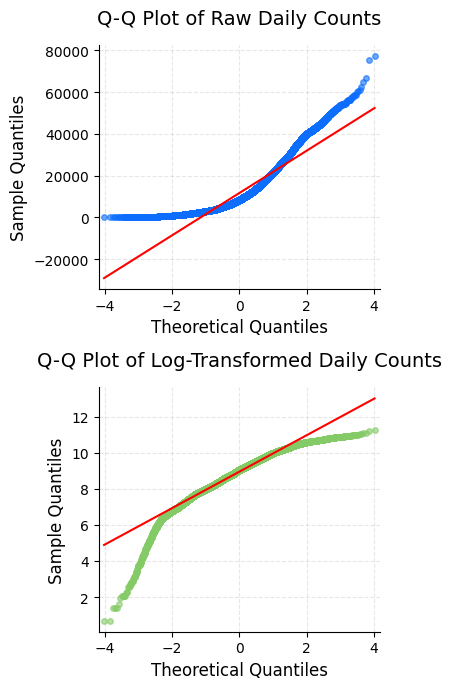

In [4]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(4, 7))

sm.qqplot(counts['daily_count'], line='s', ax=ax1, marker='o', alpha=0.6, markerfacecolor='#0d6efd', markeredgecolor='#0d6efd', markersize=4)
ax1.set_title('Q-Q Plot of Raw Daily Counts', fontsize=14, pad=15)
ax1.set_xlabel('Theoretical Quantiles', fontsize=12)
ax1.set_ylabel('Sample Quantiles', fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

sm.qqplot(log_counts['daily_count'], line='s', ax=ax2, marker='o', alpha=0.6, markerfacecolor='#84ca66', markeredgecolor='#84ca66', markersize=4)
ax2.set_title('Q-Q Plot of Log-Transformed Daily Counts', fontsize=14, pad=15)
ax2.set_xlabel('Theoretical Quantiles', fontsize=12)
ax2.set_ylabel('Sample Quantiles', fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.tight_layout()

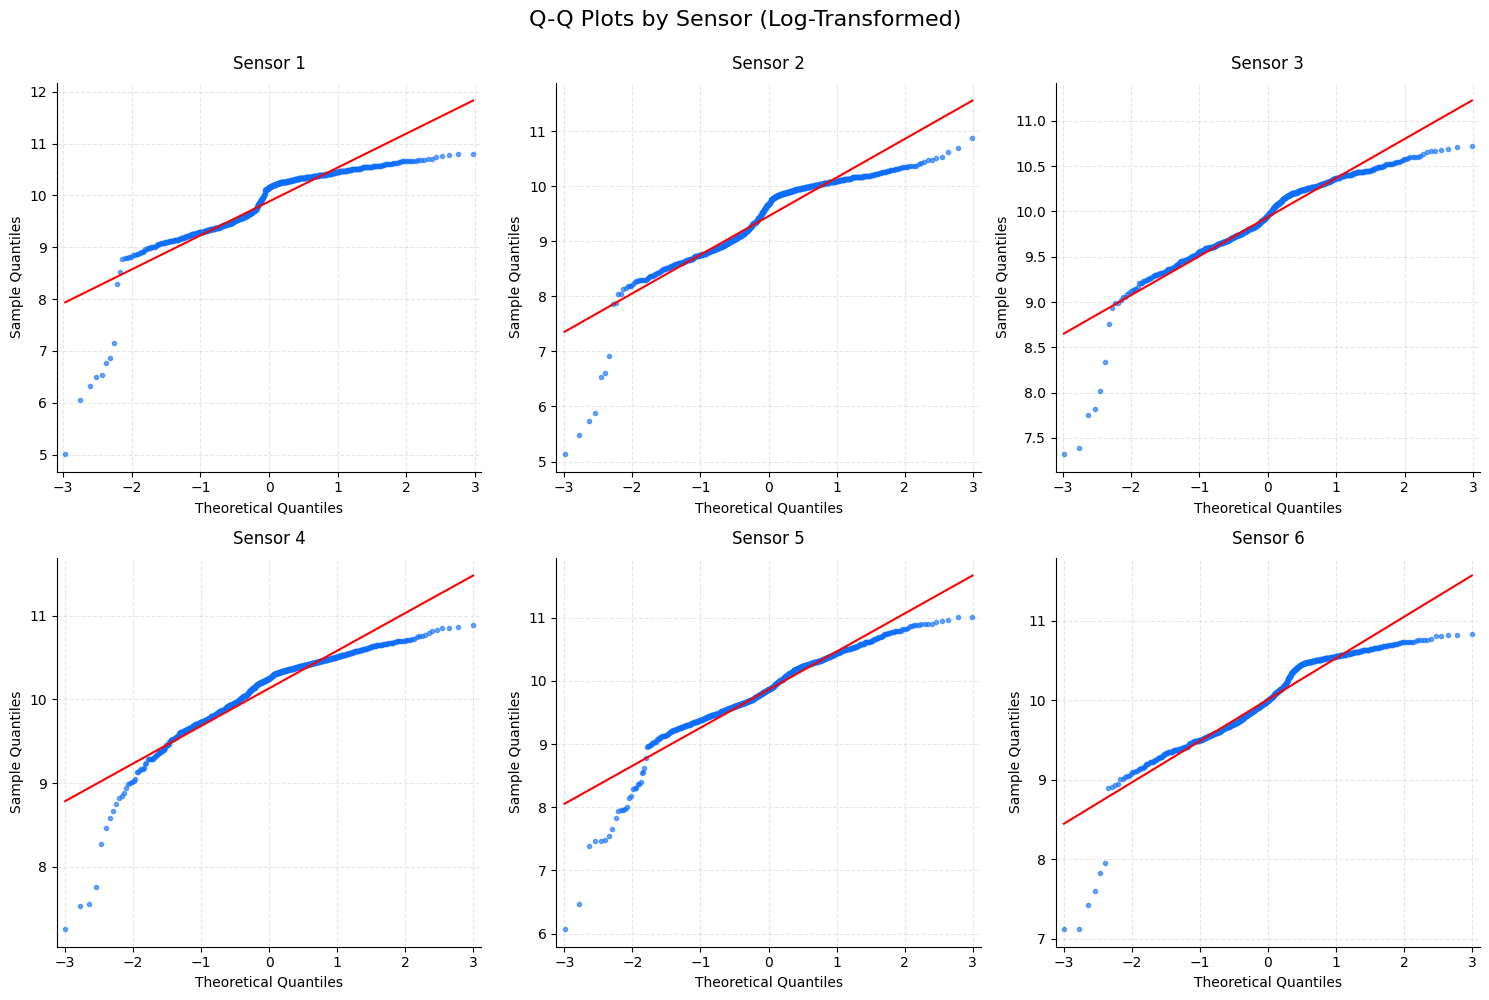

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, sensor_id in zip(axes.flat, counts['sensor_id'].unique()[:6]):
    y = counts.loc[counts['sensor_id'] == sensor_id, 'daily_count']
    sm.qqplot(np.log(y), line='s', ax=ax, marker='o', markerfacecolor='#0d6efd', markeredgecolor='#0d6efd', alpha=0.6, markersize=3)
    ax.set_title(f'Sensor {sensor_id}', fontsize=12, pad=10)
    ax.set_xlabel('Theoretical Quantiles', fontsize=10)
    ax.set_ylabel('Sample Quantiles', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle('Q-Q Plots by Sensor (Log-Transformed)', fontsize=16, y=0.995)
fig.tight_layout()

We can see from these plots that there is a heavy positive skew in the raw pedestrian counts data. This invites a log transformation which we can see improves our fit giving us a sufficiently normal distribution of counts. We can see that this distribution does have a heavy left tail which is reflected in the marginal QQ-Plots, however this effect is lessened when we consider each sensor seperatley. This arises from the variance in sensor to sensor means, however this heavy left tail persists. The effect of this should be fairly minimal in our analysis as the fit is still quite good, but it should still be considered as a source of error. 

### Model Diagnostic Plots

In [24]:
rgb_red_frac = tuple(np.divide([244, 109, 67], 256))
rgb_blu_frac = tuple(np.divide([13, 110, 253], 256))

def residual_QQ_plot(result):
    fig, ax = plt.subplots(figsize=(4, 4))
    sm.qqplot(result.resid, line='s', ax=ax, marker='o', 
              markerfacecolor=rgb_blu_frac, markeredgecolor=rgb_blu_frac, 
              alpha=0.6, markersize=4)
    for line in ax.lines:
        line.set_color(rgb_red_frac)
        line.set_linewidth(2)

    ax.set_title('Q-Q Plot: Residuals', fontsize=12, pad=10)
    ax.set_xlabel('Theoretical Quantiles', fontsize=10)
    ax.set_ylabel('Sample Quantiles', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

def random_effect_QQ_plot(result, nrows=1, titles=None):
    random_effects = pd.DataFrame.from_dict(result.random_effects, orient="index")
    
    n_effects = len(random_effects.columns)
    n_rows = nrows
    n_cols = int(np.ceil(n_effects / n_rows))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    
    # Convert to 2D array for consistent indexing
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    else:
        axes = np.atleast_2d(axes)
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Use provided titles or default to column names
    if titles is None:
        titles = random_effects.columns
    
    for ax, col, title in zip(axes_flat[:n_effects], random_effects.columns, titles):
        sm.qqplot(random_effects[col], line='s', ax=ax, marker='o', 
                  markerfacecolor=rgb_blu_frac, markeredgecolor=rgb_blu_frac, 
                  alpha=0.6, markersize=4)
        ax.set_title(f'Q-Q Plot: {title}', fontsize=12, pad=10)
        ax.set_xlabel('Theoretical Quantiles', fontsize=10)
        ax.set_ylabel('Sample Quantiles', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        for line in ax.lines:
            line.set_color(rgb_red_frac)
            line.set_linewidth(2)
    
    # Hide extra axes if any
    for ax in axes_flat[n_effects:]:
        ax.set_visible(False)
    
    fig.tight_layout()
    return fig, axes
    
def residual_fitted_plot(result):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(result.fittedvalues, result.resid, marker='o', 
               color=rgb_blu_frac, 
               alpha=0.6, s=20)
    ax.axhline(y=0, color=rgb_red_frac, linestyle='--', linewidth=2, alpha=1)
    ax.set_title('Residuals vs Fitted Values', fontsize=12, pad=10)
    ax.set_xlabel('Fitted Values', fontsize=10)
    ax.set_ylabel('Residuals', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig, ax

## Model 1
### Common day structure, sensor specific year response
In this first model we assume every sensor shares a common day-of-week pattern while allowing a unique response to year. The key assumptions here are that:
* The relative differences between days of the week stay constant across 2019 and 2025.
* Sensors have unique responses to the change in year (some areas of Melbourne may be more or less effected).

$$log(y_{i,t}) = \beta_0 + \beta_1 \text{Year}_t + \sum_{D \in \text{days} \setminus \text{Friday}} {(\beta_d 1_{t \in D})} + b_{0,i} + b_{1,i} \text{Year}_t + \varepsilon_{i,t}$$
* $log(y_{i,t})$ : Natural log of daily counts of sensor $i$ on day $t$
* $\beta_0$ : Fixed intercept of mean log daily count on a friday in 2019
* $\text{Year}_t$ : Indicator variable of whether t is in 2025 $1\{t \in 2025\}$
* $\beta_1$ : Fixed slope for year (population-average log difference between 2019 and 2025)
* $\beta_d$ : Fixed effect of day $d$ (where Friday is the reference category)
* $b_{0,i}$ : Random intercept for mean log daily count by sensor $i$, that is the log deviation from $\beta_0$ for sensor $i$
* $b_{1,i}$ : Random slope for year for sensor $i$, that is the log deviation from $\beta_1$ for sensor $i$
* $\varepsilon_{i,t}$ : Random error term for the counts on a specific sensor on day $t$, this is assumed normal $\varepsilon_{i,t} \sim N(0, \sigma^2)$

In [7]:
model_1 = smf.mixedlm(
    'daily_count ~ year + day',     # Defines the response and fixed effects
    log_counts,                       
    groups=log_counts['sensor_id'],   # Defines how to cluster the data
    re_formula='~ year'             # Random effect that differs across the clusters
)
result_1 = model_1.fit(reml=False)

print(result_1.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    daily_count
No. Observations:      34178      Method:                ML         
No. Groups:            49         Scale:                 0.2890     
Min. group size:       442        Log-Likelihood:        -27581.9033
Max. group size:       730        Converged:             Yes        
Mean group size:       697.5                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 9.265    0.124  74.459 0.000  9.021  9.509
year[T.2025]             -0.311    0.064  -4.879 0.000 -0.437 -0.186
day[T.Monday]            -0.198    0.011 -18.196 0.000 -0.220 -0.177
day[T.Saturday]          -0.224    0.011 -20.604 0.000 -0.246 -0.203
day[T.Sunday]            -0.419    0.011 -38.417 0

## Model 2
### Day-specific year effects
In this model we relax the assumption that the weekly structure is constant across 2019 and 2025. To achieve this, we introduce a fixed interaction effect $\beta_{d \times \text{Year}}$ which models how different days have been effected over time. This is supported by real world understanding as the COVID-19 pandemic introduced a significant amount of working from home measures which have remained in place. This would indicate Weekdays might be more effected from 2019 to 2025.

Importantly, this interaction effect is still treated as constant across sensors meaning that it models all areas of the city as equally effected. This is relaxed in model 3 to allow for this location variability.

$$log(y_{i,t}) = \beta_0 + \beta_1 \text{Year}_t + \sum_{D \in \text{days} \setminus \text{Friday}} {(\beta_d 1_{t \in D})} + \sum_{D \in \text{days} \setminus \text{Friday}} {(\beta_{d \times Year} (\text{Year} \cdot 1_{t \in D}))} + b_{0,i} + b_{1,i} \text{Year}_t + \varepsilon_{i,t}$$
* $log(y_{i,t})$ : Natural log of daily counts of sensor $i$ on day $t$
* $\beta_0$ : Fixed intercept of mean log daily count on a friday in 2019
* $\text{Year}_t$ : Indicator variable of whether t is in 2025 $1\{t \in 2025\}$
* $\beta_1$ : Fixed main effect of year, representing the population-average log difference between 2019 and 2025 on Fridays.
* $\beta_d$ : Fixed effect of day $d$ (where Friday is the reference category)
* $\beta_{d \times \text{Year}}$ Fixed interaction effect between day $d$ and year, representing the additional log change from 2019 to 2025 for day $d$ relative to Fridays.
* $b_{0,i}$ : Random intercept for mean log daily count by sensor $i$, that is the log deviation from $\beta_0$ for sensor $i$
* $b_{1,i}$ : Random slope for year for sensor $i$, that is the log deviation from $\beta_1$ for sensor $i$
* $\varepsilon_{i,t}$ : Random error term for the counts on a specific sensor on day $t$, this is assumed normal $\varepsilon_{i,t} \sim N(0, \sigma^2)$

In [8]:
model_2 = smf.mixedlm(
    'daily_count ~ day*year',     # Defines the response and fixed effects
    log_counts,                       
    groups=log_counts['sensor_id'],  # Defines how to cluster the data
    re_formula='~ year'            # Random effect that differs across the clusters
)
result_2 = model_2.fit(reml=False)

print(result_2.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      daily_count
No. Observations:       34178        Method:                  ML         
No. Groups:             49           Scale:                   0.2876     
Min. group size:        442          Log-Likelihood:          -27494.2870
Max. group size:        730          Converged:               Yes        
Mean group size:        697.5                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      9.292    0.125  74.544 0.000  9.048  9.536
day[T.Monday]                 -0.175    0.016 -11.216 0.000 -0.206 -0.145
day[T.Saturday]               -0.319    0.016 -20.449 0.000 -0.350 -0.289
day[T.Sunday]                 -0.493    0.016 -31.552 0.

## Model 3
### Sensor-specific Deviations in Day-Year Response (May need extra subscript in notation :/)
This final model further relaxes contraints to allow for sensor/location specific deviations how different days of the week were effected over 2019 to 2025. To simplify analysis and aid in model convergence we simplified the parameterisation for this random effect as distinguishing weekends and weekdays. This allows us to explore this effect of working from home, as well as significantly improving the fit of our model.

$$log(y_{i,t}) = \beta_0 + \beta_1 \text{Year}_t + \sum_{D \in \text{days} \setminus \text{Friday}} {(\beta_d 1_{t \in D})} + \sum_{D \in \text{days} \setminus \text{Friday}} {(\beta_{d \times Year} (\text{Year} \cdot 1_{t \in D}))} \\+ b_{0,i} + b_{1,i} \text{Year}_t + b_{2,i}\text{Weekend}_t + b_{3,i}(\text{Year}_t \cdot \text{Weekend}_t) + \varepsilon_{i,t}$$
Fixed Effects
* $\beta_0$ : Fixed Intercept. The population-average log daily count on the Reference Day (Friday) in the Reference Year (2019).
* $\text{Year}_t$ : Indicator variable for the year ($0$ for 2019, $1$ for 2025).
* $Weekend_t$ : Indicator variable equal to $0$ if Monday–Friday, or $1$ if Saturday–Sunday.
* $\beta_1$ : Fixed Main Effect of Year. The population-average log difference between 2019 and 2025 on the Reference Day (Friday).
* $\beta_d$ : Fixed Effect of Day $d$. The difference between day $d$ and the Reference Day (Friday) in 2019.
* $\beta_{d \times Y}$ : Fixed Interaction (Day $\times$ Year). The additional log change from 2019 to 2025 for day $d$ relative to the change observed on Fridays.

Random Effects (varying between sensors)
* $b_{0,i}$ : Random Intercept. The specific deviation for sensor $i$ during the Weekdays in 2019. This shifts the baseline for that sensor.
* $b_{1,i}$ : Random Slope for Year. The specific deviation for sensor $i$ regarding the change from 2019 to 2025 during Weekdays.
* $b_{2,i}$ : Random Slope for Weekend. The specific deviation for sensor $i$ that regarding the log change in pedestrian counts due to Weekends in 2019.
* $b_{3,i}$ : Random Slope for Interaction (Weekend $\cdot$ Year). The specific deviation for sensor $i$ regarding the change from 2019 to 2025 specifically on Weekends.

* $\varepsilon_{i,t}$ : Random Error. $\varepsilon_{i,t} \sim N(0, \sigma^2)$.

In [9]:
model_3 = smf.mixedlm(
    'daily_count ~ day*year',     # Defines the response and fixed effects
    log_counts,                       
    groups=log_counts['sensor_id'],  # Defines how to cluster the data
    re_formula='~ is_weekend*year'            # Random effect that differs across the clusters
)
result_3 = model_3.fit(reml=False)

print(result_3.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               daily_count
No. Observations:                34178                 Method:                           ML         
No. Groups:                      49                    Scale:                            0.2264     
Min. group size:                 442                   Log-Likelihood:                   -23575.8062
Max. group size:                 730                   Converged:                        Yes        
Mean group size:                 697.5                                                              
----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept             

In [10]:
print(result_1.aic, result_2.aic, result_3.aic)

55187.806515709555 55024.57400965493 47201.61239075917


In [11]:
re = result_3.random_effects

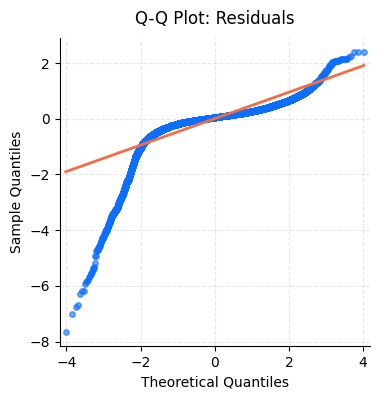

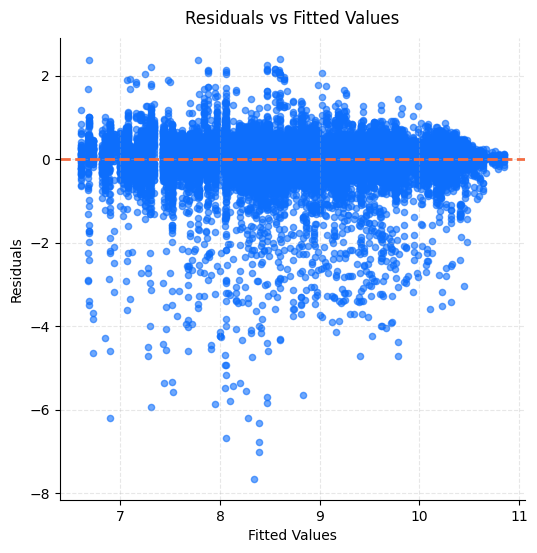

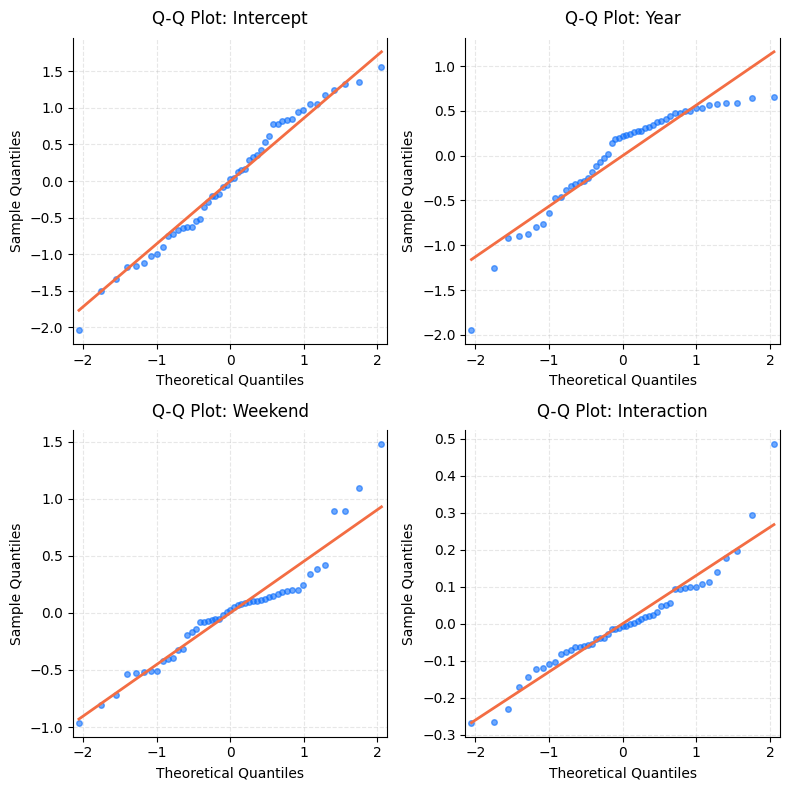

In [ ]:
# residual_QQ_plot(result_1)
# residual_fitted_plot(result_1)
# random_effect_QQ_plot(result_1)

# residual_QQ_plot(result_2)
# residual_fitted_plot(result_2)
# random_effect_QQ_plot(result_2)

fig, ax = residual_QQ_plot(result_3)
# fig.savefig(config.WEBAPP_RESOURCES_DIR / "QQresidual.png", dpi=200, transparent=True, bbox_inches='tight')

fig, ax = residual_fitted_plot(result_3)
# fig.savefig(config.WEBAPP_RESOURCES_DIR / "residualvsfitted.png", dpi=200, transparent=True, bbox_inches='tight')

fig, ax = random_effect_QQ_plot(result_3, nrows=2, titles=['Intercept', 'Year', 'Weekend', 'Interaction'])
# fig.savefig(config.WEBAPP_RESOURCES_DIR / "QQrandomeffects.svg", transparent=True, bbox_inches='tight')

We can see in the QQ-plot of residuals that we are overpredicting lower values, this means that when a sensor has low readings, the model will expect a much higher value. This heavy left tail is seen throughout our data and gives a good argument for implementing a general linear mixed model with a different distribution assumption such as a Negative Binomial to better account for this deviation. However, that is outside the scope of this project and, for the purposes of inference, this model will suffice despite this room for improvement.

We also can see this heavy left tail in the residuals vs fitted-values plot where there is a significant drift towards lower values. More worrying is the heteroskadicity as residuals decrease as we approach higher values. It should be noted that some extreme outliers are expected as these can be linked to events such as protests and New Years Eve that would significantly increase counts on specific days, but are not predicted by the model.

Inspecting the QQ-plots of random effects, we can see a generally quite good fit. There is some left skew with the effect of weekends, and a slightly heavy tail in the year and interaction effects however considering the size of our data set, this isn't too concerning.